## How to Create Environment first on your terminal 
1. conda create -n EOG_classification
2. conda activate EOG_classification
3. conda install catboost sklearn scipy numpy pywt

# import libraries

In [1]:
#!conda install catboost
import pandas as pd
from scipy import signal
from scipy import stats
from scipy.signal import butter,filtfilt, sosfiltfilt, lfilter
import matplotlib.pyplot as plt
import numpy as np
# conda install scikit-learn
from sklearn.decomposition import PCA 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pywt  #conda install pywavelets

#from catboost import CatBoostClassifier

# Helper functions

In [2]:
def signal_filter_butterworth(data_col, sr, lowcut, highcut, order=4): #1.5, 15
    """
    Apply butterworth + forward-backward digital filter on a given data column.
    Return np.array of that filtered data.

    :param data_col: np.array. Columns that only contains values from channel of interest. Shape: (500,)
    :param sr : int. Sampling Frequency (Hz)
    :param low_cut : float
    :param highcut : float
    :param order : int. Order of the filter
    """
    sos = butter(order, [lowcut, highcut], btype="bandpass", output="sos", fs=sr)
    filtered = sosfiltfilt(sos, data_col)
    return filtered

def butter_bandpass_filter(input,low_cutoff,high_cutoff,sampling_rate,order):
  nyq=0.5*sampling_rate
  low=low_cutoff/nyq
  high=high_cutoff/nyq
  numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
  filterd=filtfilt(numerator,denominator,input)
  return filterd


def mean(data):
    return np.mean(data,axis=-1)    

def var(data):
        return np.var(data,axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return [mean(data), var(data), skewness(data), kurtosis(data)]


def ploting_signal(dataframe, nrow, data_or_pre):
  n_row = dataframe.iloc[[nrow]]
  #condition = lambda x: n_row.drop(columns=['id','label']) if x == 1 else n_row.drop(columns=['label'])
  condition = lambda x: n_row.drop(columns=['instruction','label']) if x == 1 else n_row.drop(columns=['label'])
  n_row=condition(data_or_pre)
  n_row = n_row.values.tolist()
  n_row = [item for sublist in n_row for item in sublist]
  plt.figure(figsize=(12,6))
  plt.plot(np.arange(0,len(n_row)),n_row)
  plt.xlabel("t")
  plt.ylabel("a")
  plt.show()
  

def featureScalling(X): 
  for column in X.columns:
    X[column] = (X[column] - X[column].min()) /(X[column].max() - X[column].min())
  return X
  

In [3]:
def extract_features(window, lowcut, highcut, sr):
    filtered_window = np.apply_along_axis(signal_filter_butterworth, 0, window, sr, lowcut, highcut)
    # butter_bandpass_filter(n_row, low_cutoff=0.2, high_cutoff=35.0, sampling_rate=250, order=2)
    mean_values = np.mean(filtered_window, axis=0)
    std_values = np.std(filtered_window, axis=0)
    var_values = np.var(filtered_window,axis=0)
    skewness_values = stats.skew(filtered_window, axis =0)
    kurtosis_values = stats.kurtosis(filtered_window, axis =0 )

    return np.concatenate([mean_values, std_values, var_values, skewness_values, kurtosis_values])

# Models

In [4]:
def LogisticRegressionModel(X_train,y_train,X_test,y_test,iter=10000):
    model =LogisticRegression(max_iter=iter)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print('Mean Square Error:', metrics.mean_squared_error(y_test, prediction))
    print('Accuracy :', metrics.accuracy_score(y_test, prediction)) 
    return model,prediction

def random_forest(X_train,y_train,X_test,y_test):
  rf = RandomForestClassifier()
  rf.fit(X_train,y_train)
  preds = rf.predict(X_test)
  print('Accuracy :', metrics.accuracy_score(y_test, preds)) 
  return rf,preds

# Choose Subject to Process

In [5]:
sub_number = '7'
session_num = 's0'


# Load Data

In [187]:
! pwd ## Fix appropriate folder below

/Users/michellekim/Documents/GitHub/EOG_classification/NoteBook


In [188]:
# if sub_number == '4' or sub_number =='24':
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's1/' + str(sub_number) + '_data_wordBlink.csv'
# else:
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's0/' + str(sub_number) + '_data_wordBlink.csv'

# df_wordBlink= pd.read_csv(folder_path)

# if sub_number == '4' or sub_number =='24':
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's1/' + str(sub_number) + '_data_blinkGaze.csv'
# else:
#     folder_path = 'data_BlinkGaze/sub' + str(sub_number) + 's0/' + str(sub_number) + '_data_blinkGaze.csv'


folder_path = 'data_BlinkGaze/sub' + str(sub_number) + str(session_num)+ '/' + str(sub_number) + '_data_wordBlink.csv'
df_wordBlink= pd.read_csv(folder_path)

folder_path = 'data_BlinkGaze/sub' + str(sub_number)+ str(session_num)+ '/' + str(sub_number) + '_data_blinkGaze.csv'
df_blinkGaze= pd.read_csv(folder_path)

In [189]:
prepared_data_channels = df_blinkGaze
prepared_data_channels

,timestamp,eeg0,eeg1,eog0,time_seconds,blinkLabel,gazeLRLabel,gazeLeftLabel,gazeRightLabel,restLabel,whiteLabel
0,1714231575536,185757.014015,188014.551024,175309.827324,0.114,1,0,0,0,0,1
1,1714231575540,185733.194050,187982.718617,175362.112719,0.118,1,0,0,0,0,1
2,1714231575544,185707.374086,187949.886211,175489.398113,0.122,1,0,0,0,0,1
3,1714231575548,185682.554122,187913.053804,175606.683507,0.126,1,0,0,0,0,1
4,1714231575552,185658.734157,187802.221398,175635.968901,0.130,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
213314,1714233215144,54310.985075,52097.454728,90318.486797,1639.722,0,0,0,0,0,0
213315,1714233215148,54329.165111,52087.622322,90325.772192,1639.726,0,0,0,0,0,0
213316,1714233215152,54313.345146,52038.789915,90189.057586,1639.730,0,0,0,0,0,0
213317,1714233215156,54268.525182,52070.957509,90111.342980,1639.734,0,0,0,0,0,0


In [190]:
def create_label(row):
    if row['blinkLabel'] == 1:
        return 1
    elif row['gazeLeftLabel'] == 1:
        return 2
    elif row['gazeRightLabel'] == 1:
        return 3
    # elif row['whiteLabel'] == 1:
    #     return 0
    elif row['blinkLabel'] == 1:
        return 1
    else:
        return -1  # or any other default value if none of the conditions are met
    
prepared_data_channels_final = prepared_data_channels

prepared_data_channels_final['finalLabel'] = prepared_data_channels_final.apply(lambda row: create_label(row), axis=1)

prepared_data_channels_final =prepared_data_channels_final[(prepared_data_channels_final['restLabel'] != 1)]
prepared_data_channels_final = prepared_data_channels_final[(prepared_data_channels_final['finalLabel'] != -1)]

prepared_data_channels_final = prepared_data_channels_final.loc[:, ["time_seconds", "eeg0", "eeg1", "eog0", "finalLabel"]]
prepared_data_channels_final

,time_seconds,eeg0,eeg1,eog0,finalLabel
0,0.114,185757.014015,188014.551024,175309.827324,1
1,0.118,185733.194050,187982.718617,175362.112719,1
2,0.122,185707.374086,187949.886211,175489.398113,1
3,0.126,185682.554122,187913.053804,175606.683507,1
4,0.130,185658.734157,187802.221398,175635.968901,1
...,...,...,...,...,...
211134,1623.450,71854.600070,69516.684441,107559.503131,2
211135,1623.454,71859.780106,69490.852035,107474.788525,2
211136,1623.458,71704.960142,69490.019628,107451.073920,2
211137,1623.462,71684.140177,69475.187222,107357.359314,2


In [191]:
prepared_data_channels_final["finalLabel"].unique()

array([1, 3, 2])

# Fitting Model

In [192]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from scipy.signal import butter, lfilter

# sr = 250 #250
# step_size = 250 #250 # Adjust based on your data
# window_size = 500
# lowcut = 0.3
# highcut = 35

# # Assuming you have your data in DataFrames named prepared_data_channels and prepared_data_channels2
# # And assuming you have labels in the column "blinkLabel" and features in column "eog0"

# # Concatenate the two dataframes
# #combined_data = pd.concat([prepared_data_channels, prepared_data_channels2], ignore_index=True)

# combined_data = prepared_data_channels_final

# # Apply sliding window and extract features
# features = []
# labels = []

# for i in range(0, len(combined_data) - window_size, step_size):
#     window = combined_data.loc[:, ['eog0']].iloc[i:i+window_size-1, :]
#     label = combined_data["finalLabel"].iloc[i]
#     feature_vector = extract_features(window, lowcut, highcut, sr)
#     features.append(feature_vector)
#     labels.append(label)

# # Convert lists to arrays
# features = np.array(features)
# labels = np.array(labels)

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(features)

# # Split data into train and test sets
# X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.5, random_state=42)


# # Train a Random Forest classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, labels_train)

# # Predict on the test set
# y_pred = clf.predict(X_test)
# y_prob = clf.predict_proba(X_test)

# # Evaluate the model on the testing set
# accuracy = accuracy_score(labels_test, y_pred)
# f1 = f1_score(labels_test, y_pred, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# auc = roc_auc_score(labels_test, y_prob, multi_class='ovr')
# report = classification_report(labels_test, y_pred)

# print(f'Accuracy: {accuracy:.2f}')
# print(f'F1-score: {f1:.2f}')
# print(f'AUC: {auc:.2f}')
# print('Classification Report:\n', report)


# METHOD 2

# Import Data

In [193]:
def butter_bandpass_filter(input,low_cutoff,high_cutoff,sampling_rate,order):
  nyq=0.5*sampling_rate
  low=low_cutoff/nyq
  high=high_cutoff/nyq
  numerator,denominator=butter(order,[low,high],btype='band',output='ba',analog=False,fs=None)
  filterd=filtfilt(numerator,denominator,input)
  return filterd

def mean(data):
    return np.mean(data,axis=-1)    

def var(data):
        return np.var(data,axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return [mean(data), var(data), skewness(data), kurtosis(data)]

def pre_processing_Of_data_noDownsample(data, colss):
    data_framee = pd.DataFrame(columns=colss)
    for lenn in range(len(data)):
        n_row = data.iloc[[lenn]]
        label_ = str(data.iloc[lenn]['label'])
        n_row = n_row.drop(columns=['label'])
        n_row = n_row.values.tolist()
        n_row = [item for sublist in n_row for item in sublist]
        filterd_sig = butter_bandpass_filter(n_row, low_cutoff=0.2, high_cutoff=35.0, sampling_rate=250, order=2)
        
        # Removed downsampling step
        resampled__sig = filterd_sig
        flatten_array = resampled__sig.flatten()
        new_row = pd.DataFrame([[label_] + list(flatten_array)], columns=colss)
        
        # Concatenate the dataframes
        data_framee = pd.concat([data_framee, new_row], ignore_index=True)
        
    return data_framee


def create_statistical_features(coeffs, level):  

  feature_row = []
  for i in range(level + 1):
    feature_row = feature_row + concatenate_features(coeffs[i])

  return feature_row

# Select certain columns only for modeling 
# goes through data frame and drops 'id' and 'label' column 
# Uses Fourier method to resample filtered signal from buttterworth bandpass filter 
# Create and returns

def get_features(data, level,col):
  #all_coeffs = [] # each element in this list contains 4 lists for the 4 levels
  #data = pre_processed_data.drop(pre_processed_data[(pre_processed_data['polarity'] == polarity)].index, inplace=False)
  features_dataframe = pd.DataFrame(columns = col)
  for i in range(len(data)):
    row = data.iloc[[i]]
    label_ = str(data.iloc[i]['label'])
    #vertical_horizontal = str(data.iloc[i]['polarity'])
    row = row.drop(columns=['label'])
    row = row.values.tolist()
    row = [item for sublist in row for item in sublist]
    wavelet = 'db4' # Daubechies 4
    coeffs = pywt.wavedec(row, wavelet, level = level)

    frow=create_statistical_features(coeffs,level)
    #psd
    new_row = pd.DataFrame([[label_] + list(frow)], columns=col)
    features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)

  return features_dataframe

def create_statistical_features(coeffs, level):  

  feature_row = []
  for i in range(level + 1):
    feature_row = feature_row + concatenate_features(coeffs[i])

  return feature_row

def ploting_signal(dataframe, nrow, data_or_pre):
  n_row = dataframe.iloc[[nrow]]
  #condition = lambda x: n_row.drop(columns=['id','label']) if x == 1 else n_row.drop(columns=['label'])
  condition = lambda x: n_row.drop(columns=['instruction','label']) if x == 1 else n_row.drop(columns=['label'])
  n_row=condition(data_or_pre)
  n_row = n_row.values.tolist()
  n_row = [item for sublist in n_row for item in sublist]
  plt.figure(figsize=(12,6))
  plt.plot(np.arange(0,len(n_row)),n_row)
  plt.xlabel("t")
  plt.ylabel("a")
  plt.show()
  

def featureScalling(X): 
  for column in X.columns:
    X[column] = (X[column] - X[column].min()) /(X[column].max() - X[column].min())
  return X
  

In [194]:
import pandas as pd
import glob
import os


# Define the folder path
folder_path = 'data_BlinkGaze/sub'+sub_number+session_num+'/blinkGazeStudy/EOG0_reformat'

# Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Initialize an empty list to hold the DataFrames
dataframes = []

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df["channel/polarity"] = "EOG0"
    new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
    df.columns = new_column_names
    dataframes.append(df)


folder_path = 'data_BlinkGaze/sub'+sub_number+ session_num+ '/blinkGazeStudy/EEG0_reformat'
# Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df["channel/polarity"] = "EEG0"
    new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
    df.columns = new_column_names
    dataframes.append(df)


folder_path = 'data_BlinkGaze/sub'+sub_number+ session_num+ '/blinkGazeStudy/EEG1_reformat'
# Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Loop through the list of CSV files and read each one into a DataFrame
for file in csv_files:
    df = pd.read_csv(file)
    df["channel/polarity"] = "EEG1"
    new_column_names = ["label"] + [f'Sample{i}' for i in range(251)]
    df.columns = new_column_names
    dataframes.append(df)

# Choose Labels to Use

In [195]:
# Concatenate all DataFrames into one big DataFrame
all_dataframe = pd.concat(dataframes, ignore_index=True)


data = all_dataframe
data

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
0,unknown,-68379.004719,-68309.719325,-68177.433931,-68340.148537,-68365.863143,-68421.577748,-68428.292354,-68354.006960,-68357.721566,...,-68074.224714,-67907.939319,-67952.653925,-67970.368531,-67929.083137,-68003.797743,-67976.512348,-68051.226954,-67966.941560,EOG0
1,unknown,-67928.656166,-67951.370772,-67929.085377,-67951.799983,-68018.514589,-68003.229195,-68012.943800,-67901.658406,-67967.373012,...,-67833.523125,-67882.237731,-67920.952337,-67936.666943,-67912.381548,-67808.096154,-67681.810760,-67871.525366,-67901.239972,EOG0
2,unknown,-67829.954577,-67927.669183,-67917.383789,-67809.098395,-67715.813000,-67796.527606,-67881.242212,-67833.956818,-67824.671424,...,-69156.821537,-69148.536143,-69178.250748,-69072.965354,-69155.679960,-69179.394566,-69159.109172,-69239.823777,-69273.538383,EOG0
3,unknown,-69256.252989,-69219.967595,-69194.682200,-69315.396806,-69286.111412,-69300.826018,-69225.540624,-69216.255229,-69309.969835,...,-70500.119948,-70547.834554,-70654.549160,-70672.263766,-70589.978372,-70653.692977,-70659.407583,-70626.122189,-70473.836795,EOG0
4,unknown,-70511.551400,-70632.266006,-70666.980612,-70652.695218,-70542.409824,-70581.124429,-70536.839035,-70478.553641,-70610.268247,...,-71281.418360,-71293.132966,-71386.847572,-71373.562177,-71400.276783,-71229.991389,-71226.705995,-71362.420600,-71417.135206,EOG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2557,unknown,73686.694932,73672.862526,73689.030119,73738.197713,73664.365306,73718.532900,73713.700493,73689.868087,73676.035680,...,74137.637023,74145.804617,74193.972210,74123.139804,74165.307397,74216.474991,74184.642584,74166.810178,74169.977771,EEG1
2558,whiteLabel,74215.145365,74202.312958,74158.480552,74184.648145,74176.815739,74137.983332,74188.150926,74220.318519,74181.486113,...,74552.087456,74567.255049,74571.422643,74530.590236,74521.757830,74551.925423,74576.093017,74610.260610,74561.428204,EEG1
2559,unknown,74545.595797,74577.763391,74569.930984,74564.098578,74569.266171,74652.433765,74599.601358,74532.768952,74572.936545,...,74906.537888,74881.705482,74906.873075,74915.040669,74936.208262,74887.375856,74891.543449,74907.711043,74877.878636,EEG1
2560,whiteLabel,74878.046230,74901.213823,74920.381417,74966.549010,74920.716604,74895.884197,74906.051791,74907.219384,74889.386978,...,75427.988321,75479.155914,75441.323508,75432.491101,75401.658695,75410.826288,75420.993882,75421.161475,75423.329069,EEG1


In [196]:
data['label'].unique()

array(['unknown', 'blinkLabel', 'whiteLabel', 'gazeLeftLabel',
       'gazeRightLabel'], dtype=object)

In [197]:
# Define the labels of interest
#labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel', 'whiteLabel']
labels_of_interest = ['blinkLabel', 'gazeLeftLabel', 'gazeRightLabel']
# Filter the DataFrame
data_interest = data[data['label'].isin(labels_of_interest)]
data_interest

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
6,blinkLabel,-71654.148224,-71464.862829,-71562.577435,-71577.292041,-71653.006647,-71637.721252,-71563.435858,-71585.150464,-71552.865070,...,-71594.015183,-71648.729789,-71712.444395,-71761.159000,-71782.873606,-71825.588212,-71795.302818,-71668.017424,-71648.732029,EOG0
13,gazeLeftLabel,-76220.237104,-76206.951710,-76366.666316,-76344.380922,-76228.095528,-76242.810133,-76287.524739,-76356.239345,-76327.953951,...,-76577.104064,-76600.818670,-76562.533276,-76464.247881,-76507.962487,-76572.677093,-76534.391699,-76566.106304,-76648.820910,EOG0
24,blinkLabel,-74716.519632,-74646.234237,-74637.948843,-74640.663449,-74643.378055,-74592.092661,-74615.807266,-74607.521872,-74580.236478,...,-69999.386591,-69943.101197,-69939.815803,-69917.530409,-69864.245014,-69860.959620,-69796.674226,-69788.388832,-69778.103437,EOG0
28,gazeLeftLabel,-70403.713278,-70294.427884,-70202.142489,-70343.857095,-70367.571701,-70296.286307,-70307.000913,-70358.715518,-70432.430124,...,-72985.580237,-72843.294843,-73010.009449,-73049.724055,-73027.438661,-73021.153266,-73048.867872,-73044.582478,-73104.297084,EOG0
38,gazeRightLabel,-79984.697394,-79925.411999,-79936.126605,-79972.841211,-79973.555817,-79943.270422,-79917.985028,-80014.699634,-80066.414240,...,-78978.564353,-79025.278959,-79005.993565,-79040.708170,-78972.422776,-78949.137382,-78999.851988,-78959.566594,-78964.281199,EOG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,gazeLeftLabel,50156.587146,50146.754740,50144.922333,50130.089927,50110.257520,50186.425114,50215.592707,50228.760301,50182.927894,...,51934.529238,51941.696831,51880.864425,51898.032018,51951.199612,51950.367205,52020.534798,52008.702392,51973.869985,EEG1
2545,gazeRightLabel,60318.289742,60313.457335,60325.624929,60335.792522,60289.960116,60354.127709,60340.295303,60324.462896,60341.630490,...,61880.231833,61866.399426,61881.567020,61915.734613,61930.902207,61923.069800,61926.237394,61906.404987,61903.572581,EEG1
2548,blinkLabel,64380.641039,64377.808633,64322.976226,64352.143820,64376.311413,64457.479007,64421.646600,64391.814194,64406.981787,...,65485.583130,65435.750724,65474.918317,65513.085911,65541.253504,65532.421098,65498.588691,65501.756285,65521.923878,EEG1
2551,gazeRightLabel,67924.992337,67929.159930,67953.327524,67949.495117,67973.662711,67943.830304,68007.997898,67985.165491,67980.333085,...,69198.934428,69222.102022,69234.269615,69292.437209,69279.604802,69342.772396,69302.939989,69280.107582,69280.275176,EEG1


In [198]:
data_interest

,label,Sample0,Sample1,Sample2,Sample3,Sample4,Sample5,Sample6,Sample7,Sample8,...,Sample241,Sample242,Sample243,Sample244,Sample245,Sample246,Sample247,Sample248,Sample249,Sample250
6,blinkLabel,-71654.148224,-71464.862829,-71562.577435,-71577.292041,-71653.006647,-71637.721252,-71563.435858,-71585.150464,-71552.865070,...,-71594.015183,-71648.729789,-71712.444395,-71761.159000,-71782.873606,-71825.588212,-71795.302818,-71668.017424,-71648.732029,EOG0
13,gazeLeftLabel,-76220.237104,-76206.951710,-76366.666316,-76344.380922,-76228.095528,-76242.810133,-76287.524739,-76356.239345,-76327.953951,...,-76577.104064,-76600.818670,-76562.533276,-76464.247881,-76507.962487,-76572.677093,-76534.391699,-76566.106304,-76648.820910,EOG0
24,blinkLabel,-74716.519632,-74646.234237,-74637.948843,-74640.663449,-74643.378055,-74592.092661,-74615.807266,-74607.521872,-74580.236478,...,-69999.386591,-69943.101197,-69939.815803,-69917.530409,-69864.245014,-69860.959620,-69796.674226,-69788.388832,-69778.103437,EOG0
28,gazeLeftLabel,-70403.713278,-70294.427884,-70202.142489,-70343.857095,-70367.571701,-70296.286307,-70307.000913,-70358.715518,-70432.430124,...,-72985.580237,-72843.294843,-73010.009449,-73049.724055,-73027.438661,-73021.153266,-73048.867872,-73044.582478,-73104.297084,EOG0
38,gazeRightLabel,-79984.697394,-79925.411999,-79936.126605,-79972.841211,-79973.555817,-79943.270422,-79917.985028,-80014.699634,-80066.414240,...,-78978.564353,-79025.278959,-79005.993565,-79040.708170,-78972.422776,-78949.137382,-78999.851988,-78959.566594,-78964.281199,EOG0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2539,gazeLeftLabel,50156.587146,50146.754740,50144.922333,50130.089927,50110.257520,50186.425114,50215.592707,50228.760301,50182.927894,...,51934.529238,51941.696831,51880.864425,51898.032018,51951.199612,51950.367205,52020.534798,52008.702392,51973.869985,EEG1
2545,gazeRightLabel,60318.289742,60313.457335,60325.624929,60335.792522,60289.960116,60354.127709,60340.295303,60324.462896,60341.630490,...,61880.231833,61866.399426,61881.567020,61915.734613,61930.902207,61923.069800,61926.237394,61906.404987,61903.572581,EEG1
2548,blinkLabel,64380.641039,64377.808633,64322.976226,64352.143820,64376.311413,64457.479007,64421.646600,64391.814194,64406.981787,...,65485.583130,65435.750724,65474.918317,65513.085911,65541.253504,65532.421098,65498.588691,65501.756285,65521.923878,EEG1
2551,gazeRightLabel,67924.992337,67929.159930,67953.327524,67949.495117,67973.662711,67943.830304,68007.997898,67985.165491,67980.333085,...,69198.934428,69222.102022,69234.269615,69292.437209,69279.604802,69342.772396,69302.939989,69280.107582,69280.275176,EEG1


# Pre Processing

**Create an Empty Data Frame**

In [199]:
cols = ["label"] + [f"sample{i}" for i in range(50)]
cols_noDownsample = ["label"] + [f"sample{i}" for i in range(250)]
data_interest= data_interest.iloc[:, 0:251]

#pre_processed_data=pre_processing_Of_data(data, cols) --> USE THIS IF YOU WANT TO DOWNSAMPLE TO 50 
pre_processed_data_noDownsample = pre_processing_Of_data_noDownsample(data_interest, cols_noDownsample)
pre_processed_data_noDownsample

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)


,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample240,sample241,sample242,sample243,sample244,sample245,sample246,sample247,sample248,sample249
0,blinkLabel,9.835422,68.245661,92.304027,81.337908,61.137400,55.554845,70.232885,96.571687,121.273820,...,-60.173399,-46.797200,-62.521584,-102.970834,-150.330680,-184.895152,-191.566324,-164.716088,-112.175425,-48.393416
1,gazeLeftLabel,17.231475,-23.554647,-50.551000,-54.016367,-42.766952,-39.345811,-54.912349,-79.733101,-95.576614,...,122.276819,106.814818,105.904319,122.869514,144.036563,152.971392,144.992318,121.905290,83.287957,32.433763
2,blinkLabel,-732.410837,-703.449367,-684.882250,-677.563483,-675.588048,-675.294521,-677.951684,-687.316205,-708.088322,...,64.209138,46.897603,43.356209,47.665459,55.383634,64.590684,73.027652,77.428785,75.171996,67.445523
3,gazeLeftLabel,526.087926,600.501018,644.362689,653.039965,644.991554,634.510311,620.696531,604.052423,596.783424,...,83.090280,102.523949,109.489847,99.036782,83.529724,76.432038,76.866737,75.114492,63.998488,44.437743
4,gazeRightLabel,-193.913124,-173.852704,-164.039878,-164.065175,-167.880790,-175.698509,-193.393906,-219.444792,-241.771211,...,-4.779006,-20.806697,-32.635444,-37.904618,-34.519860,-25.377905,-17.700667,-15.165760,-15.666556,-16.751160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,gazeLeftLabel,-363.629966,-379.148648,-391.303479,-395.052706,-385.906772,-366.707146,-349.028048,-343.126890,-348.485771,...,64.095404,45.371567,23.681102,8.255624,7.473063,21.440099,40.586396,51.551440,45.291274,24.703737
470,gazeRightLabel,-317.559484,-319.656169,-321.651770,-323.303600,-323.285108,-321.550805,-320.843240,-322.923409,-327.126925,...,94.344329,80.842814,73.358308,75.395996,83.347625,89.480894,88.292369,79.221601,64.873179,48.297887
471,blinkLabel,-207.637420,-227.152370,-236.537931,-229.458138,-209.890421,-191.526110,-185.931347,-193.204123,-206.403758,...,-3.759051,-11.699422,-12.489115,-3.555354,10.404457,19.344738,17.830057,10.135086,4.384841,3.202133
472,gazeRightLabel,-237.921271,-230.484212,-223.387970,-217.198440,-211.894026,-206.981098,-203.249760,-201.527144,-198.465746,...,19.478171,6.517620,6.304767,19.693862,39.856044,57.121654,63.470474,56.124776,39.022505,18.299332


# Uncomment below if want to explore data more

In [200]:
# def detrend_data_new(data, order): 
#     """
#     Polyfit data with specified order and detrend each channel 
#     """
#     detrended_data = data.copy()
#     indices = np.arange(len(detrended_data))
    
#     for channel in ['eeg0', 'eeg1', 'eog0']:
#         detrended_data[channel] = detrended_data[channel].interpolate(method='linear')
#         coefficients = np.polyfit(indices, detrended_data[channel], order)
#         trend = np.polyval(coefficients, indices)
#         detrended_data[channel] = detrended_data[channel] - trend
#     return detrended_data

# ploting_signal(pre_processed_data,0,0)
# ploting_signal(pre_processed_data_noDownsample,5,0)



# Feature Extraction (Change range 20 --> 10 if downsample etc)

In [201]:
cols_features = ["label"] + [f"col{i}" for i in range(20)]
pre_processed_data_noDownsample

,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample240,sample241,sample242,sample243,sample244,sample245,sample246,sample247,sample248,sample249
0,blinkLabel,9.835422,68.245661,92.304027,81.337908,61.137400,55.554845,70.232885,96.571687,121.273820,...,-60.173399,-46.797200,-62.521584,-102.970834,-150.330680,-184.895152,-191.566324,-164.716088,-112.175425,-48.393416
1,gazeLeftLabel,17.231475,-23.554647,-50.551000,-54.016367,-42.766952,-39.345811,-54.912349,-79.733101,-95.576614,...,122.276819,106.814818,105.904319,122.869514,144.036563,152.971392,144.992318,121.905290,83.287957,32.433763
2,blinkLabel,-732.410837,-703.449367,-684.882250,-677.563483,-675.588048,-675.294521,-677.951684,-687.316205,-708.088322,...,64.209138,46.897603,43.356209,47.665459,55.383634,64.590684,73.027652,77.428785,75.171996,67.445523
3,gazeLeftLabel,526.087926,600.501018,644.362689,653.039965,644.991554,634.510311,620.696531,604.052423,596.783424,...,83.090280,102.523949,109.489847,99.036782,83.529724,76.432038,76.866737,75.114492,63.998488,44.437743
4,gazeRightLabel,-193.913124,-173.852704,-164.039878,-164.065175,-167.880790,-175.698509,-193.393906,-219.444792,-241.771211,...,-4.779006,-20.806697,-32.635444,-37.904618,-34.519860,-25.377905,-17.700667,-15.165760,-15.666556,-16.751160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,gazeLeftLabel,-363.629966,-379.148648,-391.303479,-395.052706,-385.906772,-366.707146,-349.028048,-343.126890,-348.485771,...,64.095404,45.371567,23.681102,8.255624,7.473063,21.440099,40.586396,51.551440,45.291274,24.703737
470,gazeRightLabel,-317.559484,-319.656169,-321.651770,-323.303600,-323.285108,-321.550805,-320.843240,-322.923409,-327.126925,...,94.344329,80.842814,73.358308,75.395996,83.347625,89.480894,88.292369,79.221601,64.873179,48.297887
471,blinkLabel,-207.637420,-227.152370,-236.537931,-229.458138,-209.890421,-191.526110,-185.931347,-193.204123,-206.403758,...,-3.759051,-11.699422,-12.489115,-3.555354,10.404457,19.344738,17.830057,10.135086,4.384841,3.202133
472,gazeRightLabel,-237.921271,-230.484212,-223.387970,-217.198440,-211.894026,-206.981098,-203.249760,-201.527144,-198.465746,...,19.478171,6.517620,6.304767,19.693862,39.856044,57.121654,63.470474,56.124776,39.022505,18.299332


In [202]:
pre_processed_data_noDownsample

,label,sample0,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,...,sample240,sample241,sample242,sample243,sample244,sample245,sample246,sample247,sample248,sample249
0,blinkLabel,9.835422,68.245661,92.304027,81.337908,61.137400,55.554845,70.232885,96.571687,121.273820,...,-60.173399,-46.797200,-62.521584,-102.970834,-150.330680,-184.895152,-191.566324,-164.716088,-112.175425,-48.393416
1,gazeLeftLabel,17.231475,-23.554647,-50.551000,-54.016367,-42.766952,-39.345811,-54.912349,-79.733101,-95.576614,...,122.276819,106.814818,105.904319,122.869514,144.036563,152.971392,144.992318,121.905290,83.287957,32.433763
2,blinkLabel,-732.410837,-703.449367,-684.882250,-677.563483,-675.588048,-675.294521,-677.951684,-687.316205,-708.088322,...,64.209138,46.897603,43.356209,47.665459,55.383634,64.590684,73.027652,77.428785,75.171996,67.445523
3,gazeLeftLabel,526.087926,600.501018,644.362689,653.039965,644.991554,634.510311,620.696531,604.052423,596.783424,...,83.090280,102.523949,109.489847,99.036782,83.529724,76.432038,76.866737,75.114492,63.998488,44.437743
4,gazeRightLabel,-193.913124,-173.852704,-164.039878,-164.065175,-167.880790,-175.698509,-193.393906,-219.444792,-241.771211,...,-4.779006,-20.806697,-32.635444,-37.904618,-34.519860,-25.377905,-17.700667,-15.165760,-15.666556,-16.751160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,gazeLeftLabel,-363.629966,-379.148648,-391.303479,-395.052706,-385.906772,-366.707146,-349.028048,-343.126890,-348.485771,...,64.095404,45.371567,23.681102,8.255624,7.473063,21.440099,40.586396,51.551440,45.291274,24.703737
470,gazeRightLabel,-317.559484,-319.656169,-321.651770,-323.303600,-323.285108,-321.550805,-320.843240,-322.923409,-327.126925,...,94.344329,80.842814,73.358308,75.395996,83.347625,89.480894,88.292369,79.221601,64.873179,48.297887
471,blinkLabel,-207.637420,-227.152370,-236.537931,-229.458138,-209.890421,-191.526110,-185.931347,-193.204123,-206.403758,...,-3.759051,-11.699422,-12.489115,-3.555354,10.404457,19.344738,17.830057,10.135086,4.384841,3.202133
472,gazeRightLabel,-237.921271,-230.484212,-223.387970,-217.198440,-211.894026,-206.981098,-203.249760,-201.527144,-198.465746,...,19.478171,6.517620,6.304767,19.693862,39.856044,57.121654,63.470474,56.124776,39.022505,18.299332


In [203]:
#featuered_data=get_featuers(pre_processed_data,4,cols_featuers)
featured_data=get_features(pre_processed_data_noDownsample,4,cols_features)

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)


# Label encoding

In [204]:
#label enconding for y
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = featured_data
encoded_Data=df

le = LabelEncoder()

df['encoded_label'] = le.fit_transform(df['label'])
df = df.drop(["label"], axis=1)
encoded_Data=df
encoded_Data

,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,encoded_label
0,151.008072,1.048022e+05,-0.160587,-0.364835,17.258817,3070.181829,0.462079,0.756979,-0.934732,5291.823861,...,1.603424,-0.653263,1666.602466,-0.022500,-0.522729,-0.001665,24.533758,0.000323,-0.750505,0
1,116.830586,4.238013e+04,-0.095817,-1.530891,3.345931,2658.473542,-0.565034,-0.284990,-1.579587,4127.380812,...,1.085592,1.201011,1177.941614,-0.030137,-0.833094,-0.006814,21.506743,-0.190780,-0.615224,1
2,-2542.063321,5.798007e+06,-0.315439,-0.792557,4.585760,14554.264526,-0.181123,-0.132455,8.355447,2559.061028,...,-0.823513,-0.489093,1373.429020,0.022570,-0.907779,-0.005851,20.859473,-0.028330,-0.485914,0
3,1206.331177,1.068460e+06,0.083369,-1.749034,-0.658637,2365.650993,0.972505,0.157779,1.171052,4336.571595,...,-0.308600,-1.109360,1182.502309,-0.188436,-0.182730,-0.015210,23.986685,-0.096883,-0.741714,1
4,-438.852140,2.434026e+05,-0.426231,-0.529189,21.261292,10227.612181,-1.127962,3.214797,4.497550,3670.097693,...,0.355530,-0.915077,1516.422634,0.031329,-0.954116,-0.006938,22.460660,-0.016511,-0.415206,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,-565.165047,5.109924e+05,-0.245152,-1.626846,-5.503646,525.489735,1.071169,3.005172,-0.128664,724.558690,...,-0.735732,0.243234,197.920329,0.255040,-0.593846,-0.032729,3.923498,0.076466,-0.394443,1
470,-463.477019,4.312388e+05,-0.124028,-1.699225,1.232400,926.170267,0.446989,0.781311,-6.421565,498.661913,...,0.534229,0.430501,154.437302,0.059570,-0.297763,-0.000918,2.869336,0.176564,-0.485042,2
471,-493.396413,9.997863e+04,0.149052,-1.392530,2.644182,249.869793,0.373817,1.033990,1.437874,593.756363,...,-0.984388,0.289602,158.141741,0.018860,-0.516851,0.001633,3.455237,0.058913,-0.242478,0
472,-319.309104,1.635159e+05,-0.303753,-1.467008,0.060771,941.849230,0.727412,-0.234766,3.023524,887.501251,...,-0.243278,-0.112533,105.609769,0.143103,-0.687910,-0.002015,2.948598,0.056230,-0.762200,2


In [205]:
featured_data
# blink = 0, white = 3, gazeleft = 1, gazeright = 2

,label,col0,col1,col2,col3,col4,col5,col6,col7,col8,...,col11,col12,col13,col14,col15,col16,col17,col18,col19,encoded_label
0,blinkLabel,151.008072,1.048022e+05,-0.160587,-0.364835,17.258817,3070.181829,0.462079,0.756979,-0.934732,...,1.603424,-0.653263,1666.602466,-0.022500,-0.522729,-0.001665,24.533758,0.000323,-0.750505,0
1,gazeLeftLabel,116.830586,4.238013e+04,-0.095817,-1.530891,3.345931,2658.473542,-0.565034,-0.284990,-1.579587,...,1.085592,1.201011,1177.941614,-0.030137,-0.833094,-0.006814,21.506743,-0.190780,-0.615224,1
2,blinkLabel,-2542.063321,5.798007e+06,-0.315439,-0.792557,4.585760,14554.264526,-0.181123,-0.132455,8.355447,...,-0.823513,-0.489093,1373.429020,0.022570,-0.907779,-0.005851,20.859473,-0.028330,-0.485914,0
3,gazeLeftLabel,1206.331177,1.068460e+06,0.083369,-1.749034,-0.658637,2365.650993,0.972505,0.157779,1.171052,...,-0.308600,-1.109360,1182.502309,-0.188436,-0.182730,-0.015210,23.986685,-0.096883,-0.741714,1
4,gazeRightLabel,-438.852140,2.434026e+05,-0.426231,-0.529189,21.261292,10227.612181,-1.127962,3.214797,4.497550,...,0.355530,-0.915077,1516.422634,0.031329,-0.954116,-0.006938,22.460660,-0.016511,-0.415206,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,gazeLeftLabel,-565.165047,5.109924e+05,-0.245152,-1.626846,-5.503646,525.489735,1.071169,3.005172,-0.128664,...,-0.735732,0.243234,197.920329,0.255040,-0.593846,-0.032729,3.923498,0.076466,-0.394443,1
470,gazeRightLabel,-463.477019,4.312388e+05,-0.124028,-1.699225,1.232400,926.170267,0.446989,0.781311,-6.421565,...,0.534229,0.430501,154.437302,0.059570,-0.297763,-0.000918,2.869336,0.176564,-0.485042,2
471,blinkLabel,-493.396413,9.997863e+04,0.149052,-1.392530,2.644182,249.869793,0.373817,1.033990,1.437874,...,-0.984388,0.289602,158.141741,0.018860,-0.516851,0.001633,3.455237,0.058913,-0.242478,0
472,gazeRightLabel,-319.309104,1.635159e+05,-0.303753,-1.467008,0.060771,941.849230,0.727412,-0.234766,3.023524,...,-0.243278,-0.112533,105.609769,0.143103,-0.687910,-0.002015,2.948598,0.056230,-0.762200,2


In [206]:
!pwd

/Users/michellekim/Documents/GitHub/EOG_classification/NoteBook


# Train Model

In [207]:
X=encoded_Data.drop(["encoded_label"],axis=1)
X=featureScalling(X)
y=encoded_Data[["encoded_label"]]

print(y["encoded_label"].unique())

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.3, random_state=40,stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40,stratify=y)
# print("size of training examples:  "+str(len(y_train)))
# print("size of testing examples:  "+str(len(y_test)))

print("size of training examples:  "+str(len(y_train)))
print("size of dev examples:  "+str(len(y_dev)))

X_val, X_test, y_val, y_test = train_test_split(X_dev, y_dev, test_size=0.4, random_state=40,stratify=y_dev)
print("size of validation  examples:  "+str(len(y_val)))
print("size of test examples:  "+str(len(y_test)))


[0 1 2]
size of training examples:  331
size of dev examples:  143
size of validation  examples:  85
size of test examples:  58


## Random Forest

In [208]:
model,preds=random_forest(X_train,y_train,X_val,y_val)
#model,preds=random_forest(X_train,y_train,X_dev,y_dev)

Accuracy : 0.6941176470588235


/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [209]:
# Make predictions
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

train_preds=model.predict(X_train)
train_prob = model.predict_proba(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_train, train_preds)
f1 = f1_score(y_train, train_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
auc = roc_auc_score(y_train, train_prob, multi_class='ovr')
report = classification_report(y_train, train_preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)



val_preds=model.predict(X_val)
val_prob = model.predict_proba(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, val_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
auc = roc_auc_score(y_val, val_prob, multi_class='ovr')
report = classification_report(y_val, val_preds)
print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)


train Accuracy : 1.0
Accuracy: 1.00
F1-score: 1.00
AUC: 1.00
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       228
           1       1.00      1.00      1.00        57
           2       1.00      1.00      1.00        46

    accuracy                           1.00       331
   macro avg       1.00      1.00      1.00       331
weighted avg       1.00      1.00      1.00       331

val Accuracy : 0.6941176470588235
Accuracy: 0.69
F1-score: 0.59
AUC: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.98      0.82        59
           1       0.50      0.07      0.12        14
           2       0.00      0.00      0.00        12

    accuracy                           0.69        85
   macro avg       0.40      0.35      0.31        85
weighted avg       0.57      0.69      0.59        85



/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [210]:
test_preds=model.predict(X_test)
test_prob = model.predict_proba(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 
# Evaluate the model on the testing set
accuracy = accuracy_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# auc = roc_auc_score(y_test, test_prob, multi_class='ovr')
report = classification_report(y_test, test_preds)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1-score: {f1:.2f}')
# print(f'AUC: {auc:.2f}')
print('Classification Report:\n', report)

# dev_preds=model.predict(X_dev)
# dev_prob = model.predict_proba(X_dev)
# print('test Accuracy :', metrics.accuracy_score(y_dev, dev_preds)) 
# # Evaluate the model on the testing set
# accuracy = accuracy_score(y_dev, dev_preds)
# f1 = f1_score(y_dev, dev_preds, average='weighted')  # You can choose 'micro', 'macro', 'weighted', or None
# # auc = roc_auc_score(y_test, test_prob, multi_class='ovr')
# report = classification_report(y_dev, dev_preds)

# print(f'Accuracy: {accuracy:.2f}')
# print(f'F1-score: {f1:.2f}')
# # print(f'AUC: {auc:.2f}')
# print('Classification Report:\n', report)

test Accuracy : 0.6896551724137931
Accuracy: 0.69
F1-score: 0.56
Classification Report:
               precision    recall  f1-score   support

           0       0.69      1.00      0.82        40
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         8

    accuracy                           0.69        58
   macro avg       0.23      0.33      0.27        58
weighted avg       0.48      0.69      0.56        58



/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


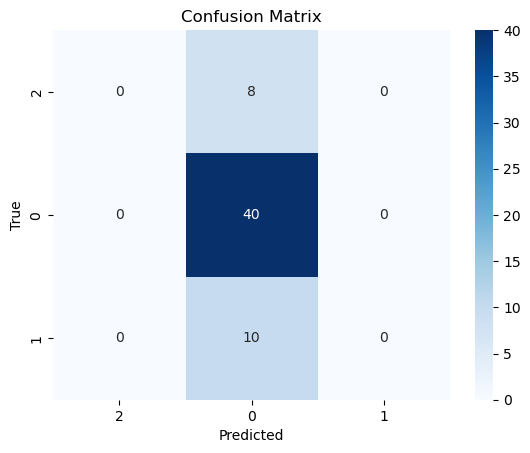

In [211]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Define the labels for the confusion matrix
labels = y_test['encoded_label'].unique()

true_label=y_test

#prediction=preds 
prediction= test_preds
# Create confusion matrix
cm = confusion_matrix(true_label,prediction, labels=labels)

# Create a dataframe from the confusion matrix
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# Create heatmap using Seaborn
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [212]:
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [213]:
predicted_blinks= 0 
predicted_leftgaze = 0
predicted_rightgaze=0 
predicted_white = 0
sub_num = sub_number

if sub_num == '4' or sub_num =='8':
    folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's1/' + str(sub_num) + '_data_wordBlink.csv'
else:
    folder_path = 'data_BlinkGaze/sub' + str(sub_num) + 's0/' + str(sub_num) + '_data_wordBlink.csv'

df = pd.read_csv(folder_path)

# get input for model
X = pre_processed_data=pre_processing_Of_data_noDownsample(data_interest, cols_noDownsample)
featuered_data=get_features(pre_processed_data,4,cols_features)

featuered_data = featuered_data.drop(columns=['label'])
featuered_data = featuered_data.fillna(0)

# Make predictions
preds=model.predict(featuered_data)
preds = preds.squeeze()
print(preds)
for pred in preds:
    if pred == 0:
        predicted_blinks += 1
    elif pred == 1:
        predicted_leftgaze += 1
    elif pred == 2: 
        predicted_rightgaze += 1
    else:
        predicted_white += 1


# blink = 0, white = 3, gazeleft = 1, gazeright = 2

print('subject ' + str(sub_num))

print('blinks: ' +  str(predicted_blinks))
print('leftgaze: ' + str(predicted_leftgaze))
print('rightgaze: ' + str(predicted_rightgaze))
print('white: ' + str(predicted_white))

#print('----------------------------------------------')

/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_framee = pd.concat([data_framee, new_row], ignore_index=True)
/var/folders/0t/prn1_49d69z01tvjtx4mt3kr0000gn/T/ipykernel_78654/2035454669.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_dataframe = pd.concat([features_dataframe, new_row], ignore_index=True)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
subject 7
blinks: 474
leftgaze: 0
righ

## Logistic Regression Model

In [214]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_val.mean()) 
X_test = X_test.fillna(X_test.mean()) 

model,preds=LogisticRegressionModel(X_train.values,y_train.values,X_val.values,y_val.values)

Mean Square Error: 0.7294117647058823
Accuracy : 0.6941176470588235


/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [215]:
# Make predictions
train_preds=model.predict(X_train)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 

test_preds=model.predict(X_val)
print('val Accuracy :', metrics.accuracy_score(y_val, test_preds)) 

test_preds=model.predict(X_test)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 

train Accuracy : 0.6858006042296072
val Accuracy : 0.6941176470588235
test Accuracy : 0.6724137931034483


/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## KNN classfier

In [216]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create a KNN classifier with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_val)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7294117647058823


/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### PCA

In [217]:
import numpy as np
from sklearn.decomposition import PCA
# create a PCA object with two components
pca = PCA(n_components=10)

# fit the PCA model to the data and transform the data
Xtrain_pca = pca.fit_transform(X_train)
Xtest_pca=pca.transform(X_test)
# print the explained variance ratio of the two principal components
print(pca.explained_variance_ratio_)

[0.19558047 0.11895345 0.09188933 0.0880387  0.07151351 0.06041663
 0.05775862 0.05630332 0.04241662 0.0407404 ]


In [218]:
model,preds=LogisticRegressionModel(Xtrain_pca,y_train,Xtest_pca,y_test)

Mean Square Error: 0.7241379310344828
Accuracy : 0.6896551724137931


/opt/anaconda3/envs/gaze/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [219]:
#after applaying pca
train_preds=model.predict(Xtrain_pca)
print('train Accuracy :', metrics.accuracy_score(y_train, train_preds)) 
test_preds=model.predict(Xtest_pca)
print('test Accuracy :', metrics.accuracy_score(y_test, test_preds)) 

train Accuracy : 0.6888217522658611
test Accuracy : 0.6896551724137931


In [185]:
# # Calculate correlation coefficient

# column1 = [0.639, 0.667, 0.694, 0.75, 0.528, 0.611, 0.722, 0.889, 0.611,  0.75, 0.639]
# column2 = [416, 236, 350, 518, 408, 14, 857, 241,879, 893, 131]
# column3 = [176, 0,0,78, 7, 5, 0,0,0,0,12]
# column4 = [0,0,0,18,0,436,0,52,25,0,0]

# r, _ = stats.pearsonr(column1, column4)

# # Number of data points
# n = len(column1)

# # Calculate t-statistic
# t_stat = r * np.sqrt((n - 2) / (1 - r**2))

# # Calculate p-value
# p_value = stats.t.sf(np.abs(t_stat), df=n-2) * 2  # two-tailed test

# # Determine significance
# alpha = 0.05
# if p_value <= alpha:
#     print(f"Significant correlation (p-value = {p_value})")
# else:
#     print(f"No significant correlation (p-value = {p_value})")

# print(f"Correlation coefficient: {r}")